In [34]:
import pickle
import requests
import networkx as nx
import json
from collections import defaultdict
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.sparse as sp
import math
from wordcloud import WordCloud


## Part 1:

### Visualization of network

b'\x80\x04\x95\r\x00\x01\x00\x00\x00\x00\x00\x8c\x18networkx.classes.digraph\x94\x8c\x07DiGraph\x94\x93\x94)\x81\x94}\x94(\x8c\x05graph\x94}\x94\x8c\x05_node\x94}\x94(\x8c\nFunkadelic\x94}\x94(\x8c\nword_count\x94M\x7f\x06\x8c\x11happiness_average\x94G@\x15\xf1\x95\xd9O\x0f\xafu\x8c\x15Parliament-Funkadelic\x94}\x94(h\x0bM\xcb\x0ch\x0cG@\x15\xe4Q\x1e\x86\t\xb1u\x8c\x18Sly and the Family Stone\x94}\x94(h\x0bM6\x15h\x0cG@\x15\xfeV\xf3o\xdb,u\x8c\x0cJimi Hendrix\x94}\x94(h\x0bMd4h\x0cG@\x15\xd0\xc7\x9e\xf8\xca\tu\x8c\x0cCream (band)\x94}\x94(h\x0bM\xd3\x0eh\x0cG@\x15\xfe\xf1\x0f\xfa4\xf9u\x8c\x11Parliament (band)\x94}\x94(h\x0bM\xb9\x03h\x0cG@\x15\xdbO\x9f\x08\x91su\x8c\x06Slayer\x94}\x94(h\x0bMp$h\x0cG@\x15\xc4T)\xc6W\x03u\x8c\nTed Nugent\x94}\x94(h\x0bM\xed\x1bh\x0cG@\x15\xa3\x07\xbbtf\xd1u\x8c\tMetallica\x94}\x94(h\x0bM\xdd+h\x0cG@\x15\xf6\xa5\xf3\xdd\x9a\xd3u\x8c\x08Megadeth\x94}\x94(h\x0bM\x03)h\x0cG@\x15\xb6~\x11N\xf5Gu\x8c\tAerosmith\x94}\x94(h\x0bM\x82.h\x0cG@\x16\x04W5\xcc\xa7\xf

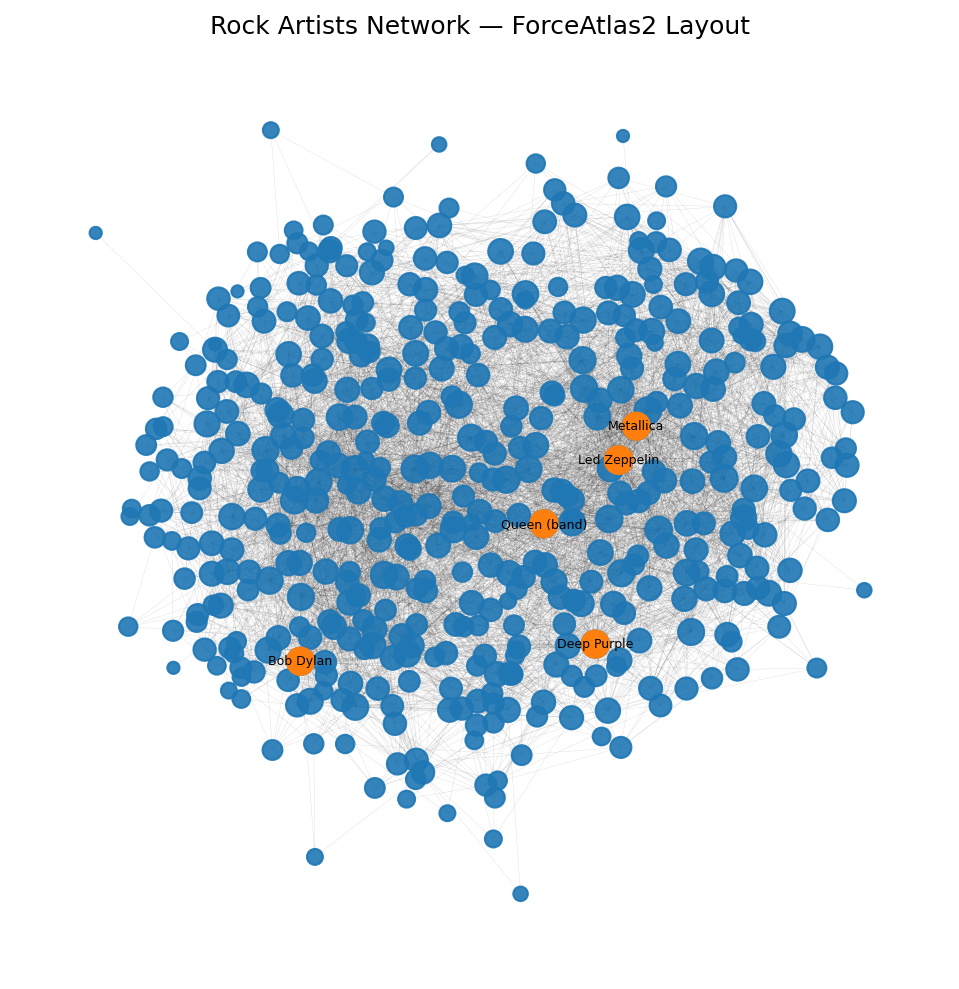

In [112]:
url = 'https://raw.githubusercontent.com/LucasJuel/socialgraphs2025/main/assignments/Assignment%202/rock_artists_network.pkl'
response = requests.get(url)
print(response.content)
G_rock = pickle.loads(response.content)

# Use largest connected component (for cleaner layout)
UG = G_rock.to_undirected() if G_rock.is_directed() else G_rock
G = UG.subgraph(max(nx.connected_components(UG), key=len)).copy()

# --- ForceAtlas2 layout (built into NetworkX)
pos = nx.forceatlas2_layout(G, gravity=1.0, seed=42)

# --- Style
deg = dict(G.degree())
sizes = 10 + 35 * np.log1p([deg[n] for n in G.nodes()])  # size ~ log(degree)

plt.figure(figsize=(8,8), dpi=150)
plt.axis("off")

nx.draw_networkx_edges(G, pos, width=0.2, alpha=0.13, edge_color="#040404")
nx.draw_networkx_nodes(G, pos, node_size=sizes, node_color="#1f77b4", alpha=0.9)
top = sorted(deg, key=deg.get, reverse=True)[:5]

nx.draw_networkx_labels(G, pos, {n: n for n in top}, font_size=6, font_color="black")
nx.draw_networkx_nodes(G, pos, nodelist=top, node_size=[sizes[list(G.nodes()).index(n)] for n in top], node_color="#ff7f0e")

plt.title("Rock Artists Network — ForceAtlas2 Layout", pad=8)
plt.show()


The network visualization above shows a directed graph of rock artists, where nodes represent artists and directed edges represent mentions from one artist to another via their corresponding wikipages. The size of each node corresponds to the total degree of the artist, indicating their overall connectivity within the network.

The top 5 artists with the highest degrees are highlighted in orange, indicating their prominence in terms of mentions. These artists are likely influential figures within the rock music community, as they are frequently referenced by other artists.

### Degree Distribution

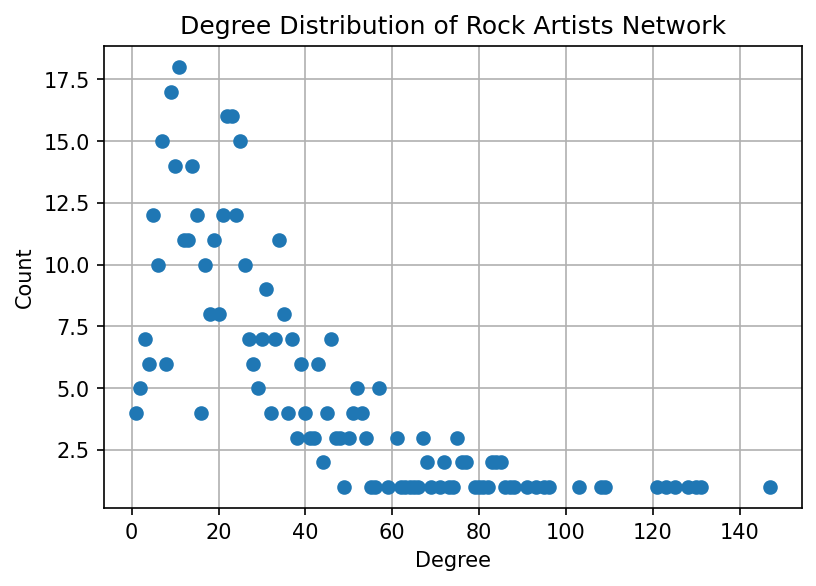

In [113]:
#Degree distribution plot
degree_sequence = sorted([d for n, d in G_rock.degree()], reverse=True)
degree_count = np.bincount(degree_sequence)
deg, cnt = np.nonzero(degree_count)[0], degree_count[np.nonzero(degree_count)[0]]
plt.figure(figsize=(6,4), dpi=150)
#plt.loglog(deg, cnt, marker='o', linestyle='None')
plt.plot(deg, cnt, 'o')
plt.title("Degree Distribution of Rock Artists Network")
plt.xlabel("Degree")
plt.ylabel("Count")
plt.grid(True)
plt.show()

The heavy-tailed nature of the degree distributions indicates that only a few artists receive a large number of links. This can be further explored while taking a look at the in-degree vs. out-degree.

/var/folders/hc/56bpy03534g1mnn80pkkb9r80000gn/T/ipykernel_61428/3219980620.py:29: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(lims)
/var/folders/hc/56bpy03534g1mnn80pkkb9r80000gn/T/ipykernel_61428/3219980620.py:30: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(lims)
/var/folders/hc/56bpy03534g1mnn80pkkb9r80000gn/T/ipykernel_61428/3219980620.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


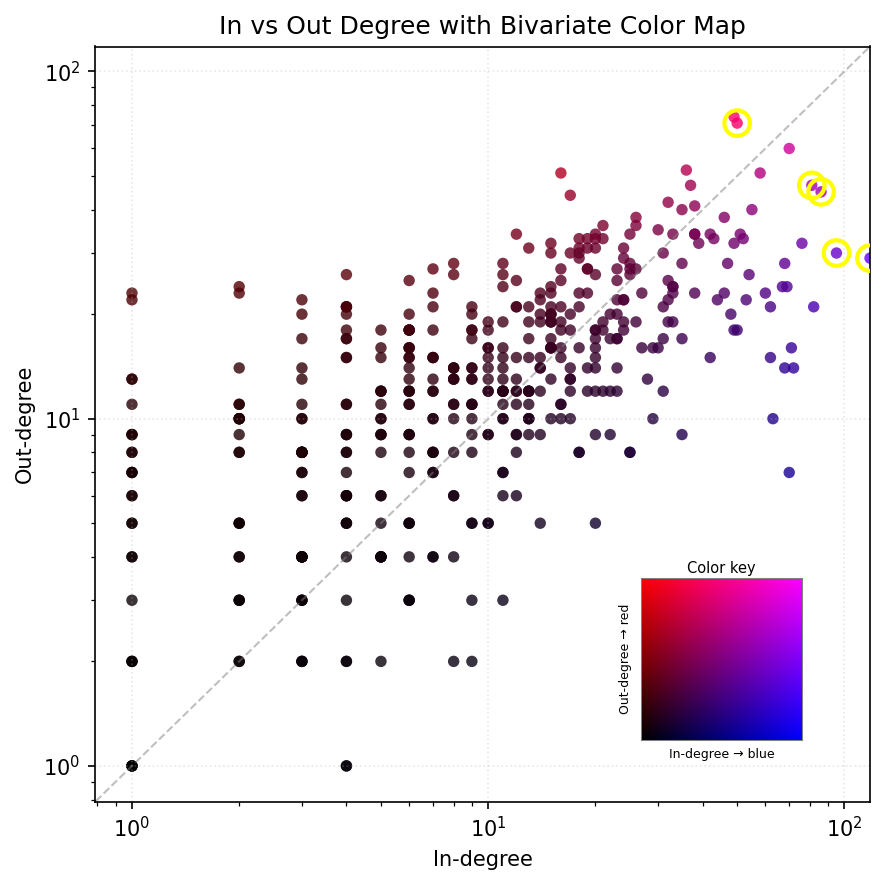

In [114]:
#In vs out degree.

# Get in/out degrees for all nodes
in_deg  = np.array([G_rock.in_degree(n)  for n in G_rock.nodes()])
out_deg = np.array([G_rock.out_degree(n) for n in G_rock.nodes()])

# Normalize degrees to [0,1] for color mixing
in_norm  = (in_deg  - in_deg.min())  / (in_deg.max()  - in_deg.min()  + 1e-9)
out_norm = (out_deg - out_deg.min()) / (out_deg.max() - out_deg.min() + 1e-9)

# Build RGB colors: red ∝ out-degree, blue ∝ in-degree
colors = np.stack([out_norm, np.zeros_like(in_norm), in_norm], axis=1)

# Scatterplot
fig, ax = plt.subplots(figsize=(6,6), dpi=150)
sc = ax.scatter(in_deg, out_deg, c=colors, s=30, alpha=0.8, edgecolor='none')

ax.set_xlabel("In-degree")
ax.set_ylabel("Out-degree")
#Make as loglog
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title("In vs Out Degree with Bivariate Color Map")
ax.grid(True, linestyle=':', alpha=0.3)

# Diagonal reference line
lims = [0, max(in_deg.max(), out_deg.max())]
ax.plot(lims, lims, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax.set_xlim(lims)
ax.set_ylim(lims)


# --- Create a small legend box showing the color meaning ---
legend_ax = fig.add_axes([0.72, 0.17, 0.18, 0.18])  # [left, bottom, width, height]
for t in top:
    x = G_rock.in_degree(t)
    y = G_rock.out_degree(t)
    ax.scatter(x, y, s=150, facecolors='none', edgecolors='yellow',
               linewidths=2.0, zorder=6)

# for l in low:
#     x = G_rock.in_degree(l)
#     y = G_rock.out_degree(l)
#     ax.scatter(x, y, s=150, facecolors='none', edgecolors='orange',
#                linewidths=2.0, zorder=6)

# make a 2D gradient: X=in, Y=out
grad = np.zeros((100, 100, 3))
for i in range(100):
    for j in range(100):
        grad[i, j, 0] = i / 99          # red = out-degree
        grad[i, j, 2] = j / 99          # blue = in-degree
legend_ax.imshow(grad, origin='lower', extent=[0,1,0,1])
legend_ax.set_xlabel("In-degree → blue", fontsize=6)
legend_ax.set_ylabel("Out-degree → red", fontsize=6)
legend_ax.set_xticks([])
legend_ax.set_yticks([])
legend_ax.set_title("Color key", fontsize=7, pad=2)
for spine in legend_ax.spines.values():
    spine.set_edgecolor('gray')
    spine.set_linewidth(0.5)
plt.tight_layout()
plt.show()

The scatterplot shows that nodes with the lowest degrees (both in-degree and out-degree) cluster near the origin (0, 0). This indicates that these artists have very few connections within the network — they rarely mention others and are rarely mentioned themselves.

The top 5 artists, highlighted in yellow, are generally positioned slightly below the diagonal reference line, meaning their in-degree is higher than their out-degree. This pattern suggests that these popular artists are referenced more often by others than they themselves reference others, reflecting a hierarchical structure where attention and influence flow primarily toward well-known figures.

### Centrality and assortativity analysis

It is also interesting to take a look at the centrality of the network, and since the structure seems slightly hierarchical, it would make sense to analyze centrality based on the in-degree. The top 5 artists in terms of in-degrees are:

In [115]:
for i in sorted([n for n, d in G_rock.in_degree() if d > 0], key=lambda x: G_rock.in_degree(x), reverse=True)[:5]:
    print(f"{i} - in-degree: {G_rock.in_degree(i)}, out-degree: {G_rock.out_degree(i)}")

# print("\n")

# for i in sorted([n for n, d in G_rock.out_degree() if d > 0], key=lambda x: G_rock.out_degree(x), reverse=True)[:5]:
#     print(i)

Led Zeppelin - in-degree: 118, out-degree: 29
Bob Dylan - in-degree: 95, out-degree: 30
Queen (band) - in-degree: 86, out-degree: 45
David Bowie - in-degree: 82, out-degree: 21
Metallica - in-degree: 81, out-degree: 47


This pattern indicates that the most central artists are primarily targets of references from other artists, rather than being prolific in referencing others themselves. They function as key cultural touchstone - pages that many other artists link to in order to contextualize their own work and styles. 

The strong overlap between the top artists by in-degree and total degree further supports the idea that cultural influence and connectivity are closely related.

This assumption that top artists are primarily targets of references can be backed up by looking at the assortativity of the network.


In [116]:
G_rock = G_rock.to_directed()
outin = nx.degree_pearson_correlation_coefficient(G_rock, x='out', y='in')
inin = nx.degree_pearson_correlation_coefficient(G_rock, x='in', y='in')
print(f"Out-In assortativity: {outin:.4f}")
print(f"In-In assortativity: {inin:.4f}")


Out-In assortativity: 0.0339
In-In assortativity: 0.0731


The out-in assortativity is slightly positive, indicating a weak tendency for artists with high out-degree link to those who has high in-degree. This suggests that artists who frequently reference others tend to mention popular artists who are widely referenced themselves.

The stronger in-in assortativity indicates that artists who are frequently referenced by others tend to be linked to other popular artists. This suggests a clustering effect among influential artists, where they are more likely to reference each other, forming a tightly-knit community within the larger network.

By taking a closer look at the rich-club coefficient, the tendency for popular artists to reference other popular artists can be further explored.


### Rich-Club network backbone

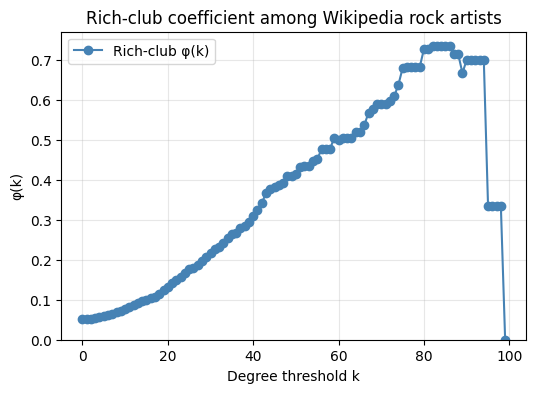

In [117]:
H = G_rock.to_undirected()
phi = nx.rich_club_coefficient(H, normalized=False)
ks, vals = zip(*sorted(phi.items()))

plt.figure(figsize=(6,4))
plt.plot(ks, vals, marker='o', linestyle='-', color='steelblue', label='Rich-club φ(k)')
plt.xlabel('Degree threshold k')
plt.ylabel('φ(k)')
plt.title('Rich-club coefficient among Wikipedia rock artists')
plt.ylim(bottom=0)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

The non-normalized rich-club coefficient increases with the degree threshold k. This indicates that nodes with higher degrees tend to be more interconnected among themselves compared to nodes with lower degrees. In other words, as we consider nodes with increasing degree thresholds, the likelihood of these high-degree nodes being connected to each other also increases. This pattern suggests the presence of a "rich-club" phenomenon in the network, where influential or well-connected artists are more likely to reference each other, forming a tightly-knit community within the larger network of rock artists.

## Conclusion
Overall, the network reveals a structure that is slightly hierarchical, with a few highly influential artists receiving the majority of references. The assortativity and rich-club analysis further highlight the tendency for popular artists to cluster together, reinforcing their cultural significance within the rock music community.

## Part 2:

### Write about genres and modularity
So far analysis has focused on how rock artists are connected to each other through references on their wiki page. Each of these rock artists are associated with sub-genres based on the info box on their wiki page. Artists who shares a sub-genre likely have the same inspirations, or maybe they have colloborations. Therefore, a hypothesis can be made here, that artists that are characterized by the same sub-genre is more likely to be linked together compared to other artists.

### Testing the hypothesis with modularity

One way to test this hypothesis could be to use modularity. If each collection of artists within a certain sub-genre is considered as a community, then modularity could be used to show the interconnectivity between genres. Modularity is the measure of the quality of the partition between communitites. A high modularity indicates that the amount edges going between communities is very low. Therefore, a high modularity would suggest that artists are more densely connected within their sub-genres than between different sub-genres, supporting the hypothesis.

### Detecting the communities and calculating the modularity

With this information we will now create a network that are associated a genre and detect the communities. 

In [118]:
url2 = 'https://raw.githubusercontent.com/LucasJuel/socialgraphs2025/main/assignments/Assignment%202/artist_genres_without_rock.json'
response2 = requests.get(url2)
artist_genres = response2.json()

"""
Create a new network with only nodes that have genres,
and assign primary genre as node attribute
"""
# Create new graph but force it to be undirected

G_rock = G_rock.to_undirected()

G_filtered = nx.Graph()

# Map nodes to their primary genre
node_to_primary_genre = {}

for node in G_rock.nodes():
    # Check if node has genres (handle various naming formats)
    node_name = str(node)
    
    # Try different variations of the node name
    variations = [
        node_name,
        node_name.replace('_', ' '),
        node_name.replace(' ', '_'),
        node_name.replace('(band)', '').strip()
    ]
    
    genres = None
    for variant in variations:
        if variant in artist_genres and artist_genres[variant]:
            genres = artist_genres[variant]
            break
    
    if genres:
        # Use first genre as primary genre
        primary_genre = genres[0]
        node_to_primary_genre[node] = primary_genre
        G_filtered.add_node(node, genre=primary_genre, all_genres=genres)

# Add edges between nodes that both have genres
for u, v in G_rock.edges():
    if u in node_to_primary_genre and v in node_to_primary_genre:
        # Copy edge attributes if they exist
        edge_data = G_rock.get_edge_data(u, v)
        if edge_data:
            G_filtered.add_edge(u, v, **edge_data)
        else:
            G_filtered.add_edge(u, v)


genre_to_nodes = defaultdict(list)

for node, genre in node_to_primary_genre.items():
    genre_to_nodes[genre].append(node)

# Convert to list of communities (sets)
communities = [set(nodes) for nodes in genre_to_nodes.values()]


"""
Main analysis function
"""

print(f"Original network: {G_rock.number_of_nodes()} nodes, {G_rock.number_of_edges()} edges")

print(f"Filtered network: {G_filtered.number_of_nodes()} nodes, {G_filtered.number_of_edges()} edges")
print(f"Removed {G_rock.number_of_nodes() - G_filtered.number_of_nodes()} nodes without genres")

# Print community statistics
print(f"\nFound {len(communities)} genre communities:")
for genre, nodes in sorted(genre_to_nodes.items(), key=lambda x: len(x[1]), reverse=True):
    print(f"  {genre}: {len(nodes)} nodes")

# Additional analysis
print("\nAdditional statistics:")

# Average degree by genre
print("\nAverage degree by genre:")
for genre, nodes in sorted(genre_to_nodes.items(), key=lambda x: len(x[1]), reverse=True)[:10]:
    degrees = [G_filtered.degree(node) for node in nodes if node in G_filtered]
    if degrees:
        avg_degree = np.mean(degrees)
        print(f"  {genre}: {avg_degree:.2f}")

with open("filtered_rock_artists_network.pkl", 'wb') as f:
    pickle.dump(G_filtered, f)



Original network: 484 nodes, 5943 edges
Filtered network: 448 nodes, 5170 edges
Removed 36 nodes without genres

Found 91 genre communities:
  alternative rock: 64 nodes
  hard rock: 50 nodes
  pop rock: 25 nodes
  pop music: 21 nodes
  progressive rock: 16 nodes
  rock and roll: 15 nodes
  heavy metal music: 14 nodes
  new wave music: 13 nodes
  indie rock: 12 nodes
  post-grunge: 10 nodes
  blues rock: 10 nodes
  folk rock: 10 nodes
  alternative metal: 9 nodes
  punk rock: 9 nodes
  soft rock: 9 nodes
  pop-punk: 8 nodes
  art rock: 7 nodes
  arena rock: 7 nodes
  southern rock: 6 nodes
  nu metal: 5 nodes
  heartland rock: 5 nodes
  psychedelic rock: 4 nodes
  groove metal: 4 nodes
  industrial rock: 4 nodes
  blues: 4 nodes
  funk: 3 nodes
  grunge: 3 nodes
  hip-hop: 3 nodes
  glam metal: 3 nodes
  roots rock: 3 nodes
  beat music: 3 nodes
  country rock: 3 nodes
  country music: 3 nodes
  glam rock: 3 nodes
  instrumental rock: 3 nodes
  post-punk: 3 nodes
  jazz rock: 3 nodes
 

The script detected 91 communities, each representing a unique sub-genre. Next the modularity of the communities can be found.

In [119]:
# NetworkX expects communities as list of sets
modularity = nx.community.modularity(G_filtered, communities)

total_edges = G_filtered.number_of_edges()

modularity_calculation = 0.0

for community in communities:
    # Calculate Lc: number of edges WITHIN this community
    Lc = 0
    for node1 in community:
        for node2 in community:
            if G_filtered.has_edge(node1, node2):
                Lc += 1
    Lc = Lc / 2  # Each edge was counted twice
    # Calculate kc: sum of degrees of nodes in community

    kc = sum(G_filtered.degree(node) for node in community)

    modularity_calculation += (Lc/total_edges - (kc/(2*total_edges)) ** 2)



print(f"Modularity of genre-based communities: {modularity:.4f}")
print(f"Modularity calculation check (not normalized): {modularity_calculation:.4f}")


Modularity of genre-based communities: 0.0885
Modularity calculation check (not normalized): 0.0885


In [120]:
with open('artist_genres_without_rock.json', 'r', encoding='utf-8') as f:
    artist_genres = json.load(f)

# Calculate total number of genres across all artists
total_genres = sum(len(genres) for genres in artist_genres.values())

# Calculate average
num_artists = len(artist_genres)
average_genres = total_genres / num_artists

print(f"Average genres per artist: {average_genres:.2f}")

Average genres per artist: 4.37


### Detect the communities, discuss the value of modularity in comparison to the genres.

It was possible to detect genres for 448 nodes. The modularity was calculated using formula 8.12 in the book and also confirmed using the NetworkX built in function. 

In the initial data processing, it could be seen that, "rock" and "rock music" was the primary genre for most nodes. This network had a very low modularity of 0.0956 and thus the communities was quite interconnected. However it could be argued that "rock" and "rock music" is really the umbrella term for all sub genres. Therefore a new graph was calculated excluding these. Which resulted in a even lower modularity of 0.0885. This suggests a very weak community structure, and indicates that nodes within the same genre are only slightly more likely to be connected, than being connected to random nodes. This does not support the proposed hypothesis. 

The low modularity could be explained by high cross genre influence, or simply be due to the fact that sub-genres are not that distint from each other. With an average of 4.37 sub-genres per artists, it suggests that many artists cross between different sub-genres, and therefore do not belong in a specific sub-genre community. Since the sub-genre that was picked as the main genre for each artist, was simply the first sub-genre in the list, it was more or less random which genre was considered the primary one. Therefore it makes sense that the modularity is low, since every node could arguably belong to a different community. 

### Calculating the D matrix

In this sub assignment, the D matrix is constructed using only the 7 most common genres and the 7 most common communities (excluding "rock" and "rock music"). When making the original "artist_genres_without_rock.json", the following genres were found to be most common.

- alternative rock: 135 artists 
- hard rock: 132 artists
- pop rock: 105 artists
- alternative metal: 53 artists
- blues rock: 50 artists
- pop: 50 artists
- heavy metal music: 50 artists
- pop music: 49 artists
- heavy metal: 48 artists

In [121]:
"""
Calculate the degree matrix D (diagonal matrix with node degrees)
"""

n = 7
node_list = list(G_filtered.nodes())
D = np.zeros((n, n))

most_common_genre = ["alternative rock", "hard rock", "pop rock", "alternative metal", "blues rock", "pop", "heavy metal music"]


# Get top n genres by community size
top_communities = []
for genre, nodes in sorted(genre_to_nodes.items(), key=lambda x: len(x[1]), reverse=True)[:n]:
    top_communities.append(genre)


for i, genre1 in enumerate(most_common_genre):
    if genre1 not in genre_to_nodes:
        print(f"Warning: '{genre1}' not found in data, skipping...")
        continue
        
    nodes1 = genre_to_nodes[genre1]
    
    for j, genre2 in enumerate(top_communities):
        nodes2 = genre_to_nodes[genre2]
        
        # Count edges between nodes of these two genres
        edge_count = 0
        for node1 in nodes1:
            for node2 in nodes2:
                if G_filtered.has_edge(node1, node2):
                    edge_count += 1
        
        # If same genre, divide by 2 (each edge counted twice)
        if genre1 == genre2:
            edge_count = edge_count // 2
            
        D[i, j] = edge_count
    

# Print with nice formatting
print("\nGenre Connectivity Matrix:")
print("="*50)

# Print as DataFrame for better readability
df = pd.DataFrame(D, index=most_common_genre, columns=top_communities)
df = df.astype(int)  # Convert to integers for cleaner display
print(df)

# Print some statistics
print("\n" + "="*50)
print("Matrix Statistics:")
print(f"Total edges in matrix: {int(np.sum(D))}")
print(f"Diagonal sum (within-genre edges): {int(np.sum(np.diag(D)))}")
print(f"Off-diagonal sum (between-genre edges): {int(np.sum(D) - np.sum(np.diag(D)))}")




Genre Connectivity Matrix:
                   alternative rock  hard rock  pop rock  pop music  \
alternative rock                182        109        54         57   
hard rock                       109        191        37         56   
pop rock                         54         37        11         48   
alternative metal                48         34         3          5   
blues rock                        7         13         2          3   
pop                               1          6         5          6   
heavy metal music                26        116        10         12   

                   progressive rock  rock and roll  heavy metal music  
alternative rock                 40             12                 26  
hard rock                        61             27                116  
pop rock                         17             12                 10  
alternative metal                14              2                 25  
blues rock                        3        

### Analysis of the D-matrix
From the D-matrix it can be observed that majority of edges are between genre edges, with only 26.4% of edges being within genre. This further weakens the hypothesis, since the majority of edges goes accross genres. It is in line with the low modularity that was found, since high modularity within community edges should be higher than between community edges. This all suggests that nodes are highly interconnected. 

It is also interesting that a genre like pop, which was found in 50 artists, have nearly no connections to any of the communities. Likewise, blues rock have very few connections. That suggests, even though these genres are not well represented in the communities, they were found in a lot of artists. Indicating that the communities are not a good representation of the distribution of genres. 


### Plotting the communities

The top communities are plotted to show their grouping.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib/cbook.py:1044: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


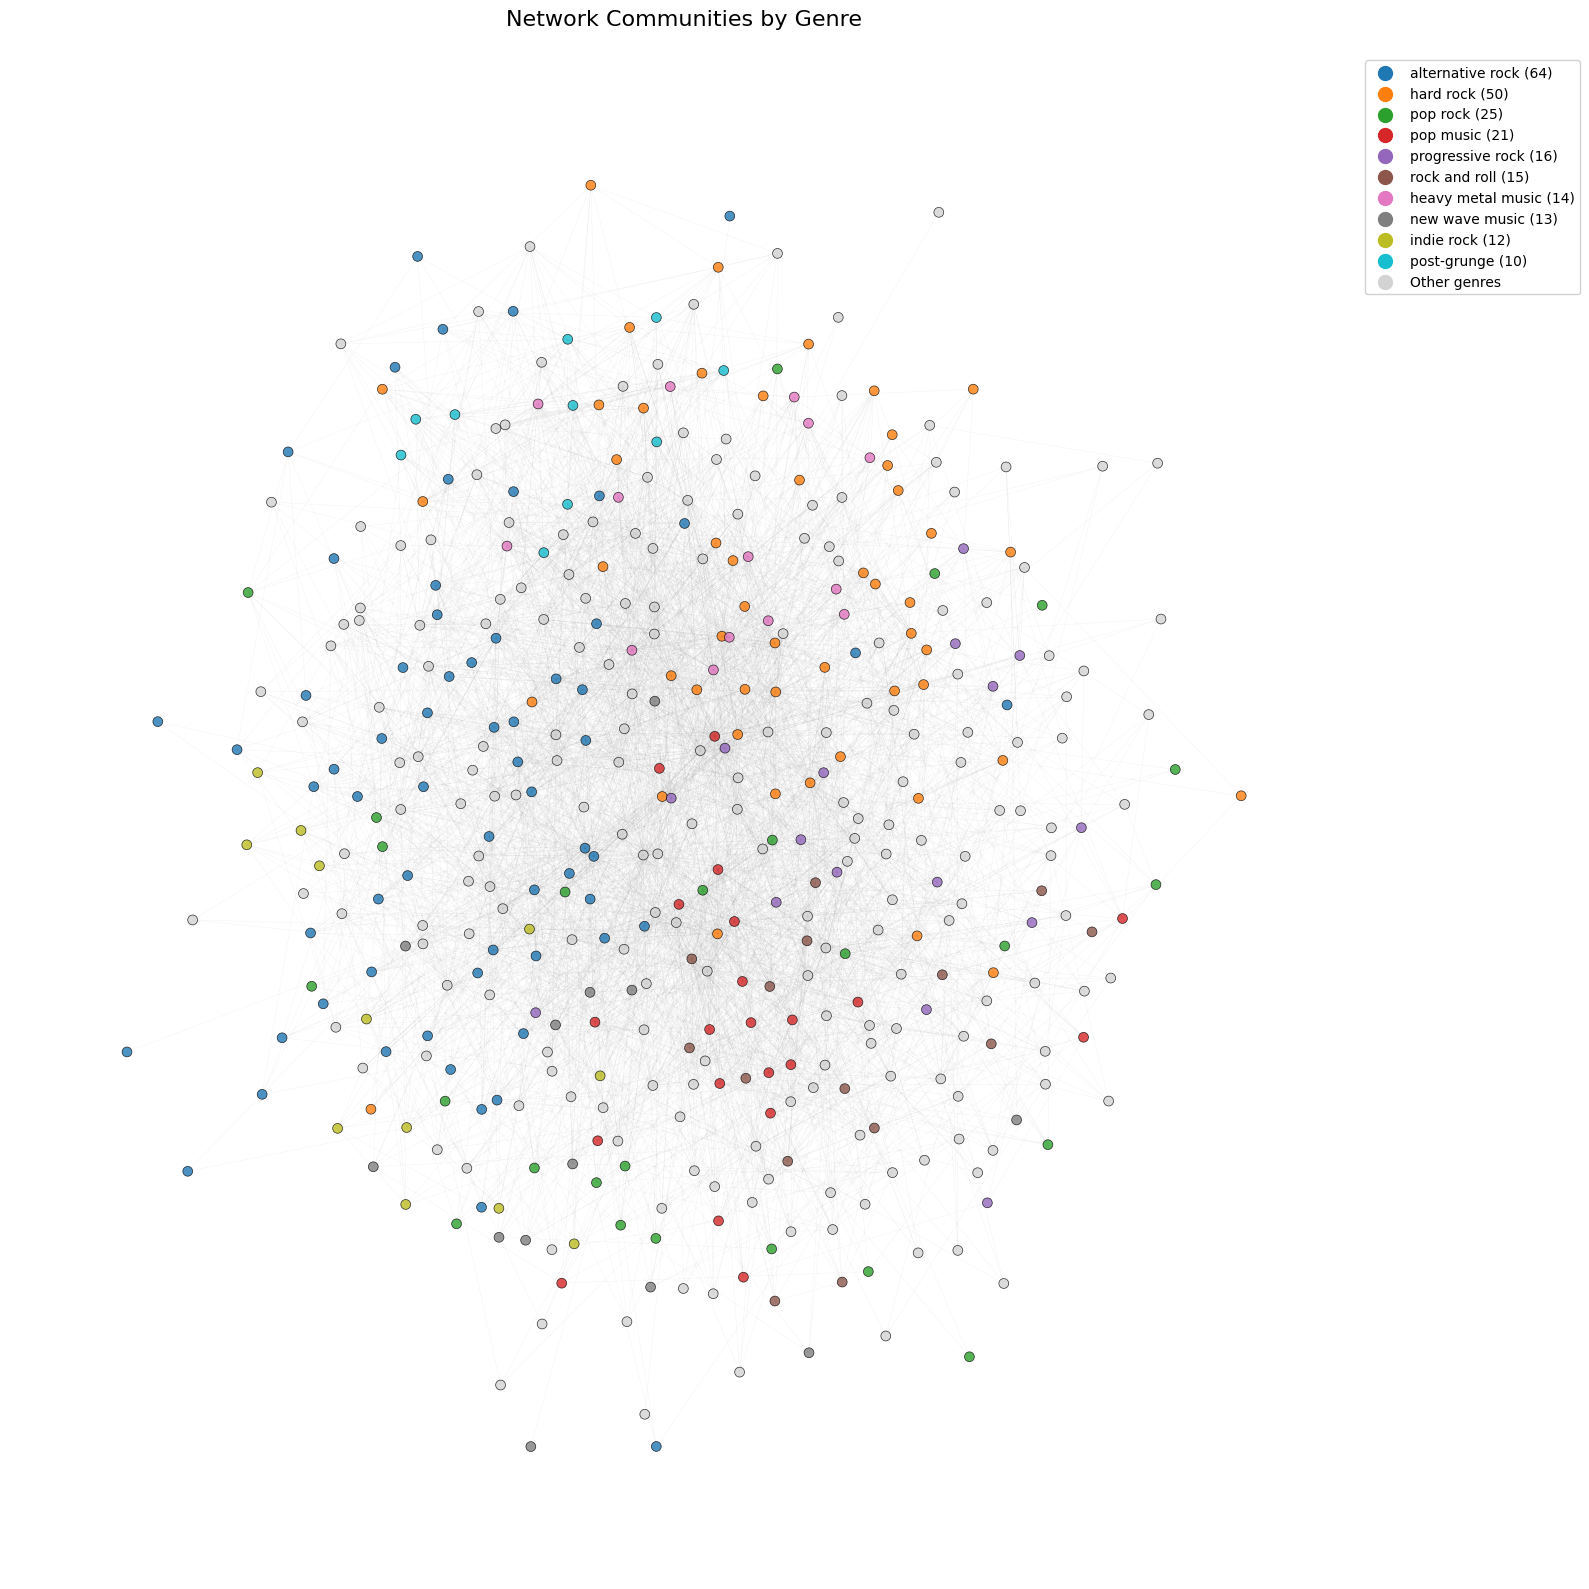

In [122]:
plt.figure(figsize=(16, 16))

# Create color map for top genres only (to reduce visual clutter)
top_genres = sorted(genre_to_nodes.items(), key=lambda x: len(x[1]), reverse=True)[:10]
top_genre_names = [g[0] for g in top_genres]

# Use distinct colors
colors = plt.cm.tab10(np.linspace(0, 1, 10))
genre_to_color = dict(zip(top_genre_names, colors))

# Assign colors - group small genres as "Other"
node_colors = []
for node in G_filtered.nodes():
    node_genre = G_filtered.nodes[node].get('genre', 'unknown')
    if node_genre in genre_to_color:
        node_colors.append(genre_to_color[node_genre])
    else:
        node_colors.append('lightgray')

# Use Kamada-Kawai layout for better community separation
# or try: pos = nx.spring_layout(G_filtered, k=1.5, iterations=100, seed=42)
pos = nx.kamada_kawai_layout(G_filtered)

# Draw edges first (so they're in background)
nx.draw_networkx_edges(G_filtered, pos, alpha=0.1, width=0.3, edge_color='gray')

# Draw nodes
nx.draw_networkx_nodes(G_filtered, pos, node_color=node_colors, 
                        node_size=50, alpha=0.8, linewidths=0.5, edgecolors='black')

# Create legend
legend_elements = []
for genre, nodes in top_genres:
    legend_elements.append(plt.scatter([], [], c=[genre_to_color[genre]], 
                                      s=100, label=f'{genre} ({len(nodes)})'))
legend_elements.append(plt.scatter([], [], c='lightgray', s=100, label='Other genres'))

plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1), 
           fontsize=10, framealpha=0.9)
plt.title("Network Communities by Genre", fontsize=16, pad=20)
plt.axis('off')
plt.tight_layout()
plt.show()

The plot more or less confirms what was suspected with the low modularity. There is no clear partition between the communities, with many edges going between genres. With 91 communities it is also clear that there are many smaller communities. 

### Conclusion

It can be concluded that there is very little evidence supporting the hypothesis of bands within the same subgenre being more linked than others. The analysis has shown a low modularity, that indicates a poor partition between genres, and further research like the D-matrix shows the majority of edges are between genres, not within the same genre. Lastly the plot shows no clear partition between the genres. Therefore, it can be concluded that there is no significant evidence suggesting artists within the same sub-genre are more linked than others.

## Part 3

### Explain the concept of TF-IDF in your own words and how it can help you understand the genres and communities.

Term Frequency-Inverse Document Frequency is a measure that shows the importance of a word in relation to a document as a part of a collection. Meaning it is a variable that tracks how often a word is mentionend in the document, and then compares it with how infrequent it is mentioned in the whole collection. Words that are often mentionend in a document but very infrequent in the collection, have a high TF-IDF score and is therefore considered important. 

This could be useful in figuring out which words best describe a genre. By going through each wiki page in a community and calculating a TD-IDF score for each, it would be possible to see which words was important for that genre.

In [30]:
# Sort all artists into corresponding genres
import re


top = sorted(genre_to_nodes.items(), key=lambda x: len(x[1]), reverse=True)[:15]

freq_words_to_genre = {}
for genre, nodes in top:
    print(f"Processing genre: {genre} with {len(nodes)} nodes")
    collected_text = ""
    for node in nodes:
        #print(node)
        file_path = f"wiki_pages/{node.replace(' ', '_')}.txt"
        # Read the file
        with open(file_path, 'r', encoding='utf-8') as f:
            text = f.read()

        # First remove common wiki markup
        clean_text = text
        clean_text = re.sub(r'\[\[.*?\]\]', ' ', clean_text)  # Remove links
        clean_text = re.sub(r'\{\{.*?\}\}', ' ', clean_text)  # Remove templates
        clean_text = re.sub(r'<.*?>', ' ', clean_text)  # Remove HTML tags
        clean_text = re.sub(r'==.*?==', ' ', clean_text)  # Remove headers
        clean_text = re.sub(r'\|.*?\|', ' ', clean_text)  # Remove table markup
        collected_text += " " + clean_text
    
    #print(f"Collected text length for genre '{genre}': {len(collected_text)} characters")
    word_freq = {}
    regex_collected_text = re.findall(r'\b[a-zA-Z]{4,}\b', collected_text.lower())

    for idx, word in enumerate(set(regex_collected_text)):
        #Print progrss:
        #print(f"Progress: {idx+1}/{len(set(regex_collected_text))}", end='\r')
        for word2 in regex_collected_text:
            if word == word2:  # Ignore very short words
                word_freq[word] = word_freq.get(word, 0) + 1
    
    freq_words_to_genre[genre] = word_freq
    
    



Processing genre: alternative rock with 64 nodes


In [31]:
with open("genre_frequent_words.json", 'w', encoding='utf-8') as f:
    json.dump(freq_words_to_genre, f, indent=2)

In [35]:
# Step 1: Calculate which genres contain each word (for IDF)
word_in_genres = defaultdict(set)
for genre, word_freq in freq_words_to_genre.items():
    for word in word_freq.keys():
        word_in_genres[word].add(genre)

# Step 2: Calculate IDF for each word
total_genres = len(freq_words_to_genre)
word_idf = {}


for word, genres_set in word_in_genres.items():
    # IDF = log(total number of genres / number of genres containing the word)
    idf = math.log(total_genres / len(genres_set))
    word_idf[word] = idf

# Step 3: Calculate TF-IDF for each word in each genre
genre_tfidf = {}

for genre, word_freq in freq_words_to_genre.items():
    # Calculate total words in this genre for TF normalization
    total_words = sum(word_freq.values())
    
    # Calculate TF-IDF for each word
    tfidf_scores = {}
    for word, count in word_freq.items():
        # TF = word count / total words in genre
        tf = count / total_words
        
        # TF-IDF = TF * IDF
        tfidf = tf * word_idf[word]
        tfidf_scores[word] = tfidf
    
    genre_tfidf[genre] = tfidf_scores

# Step 4: View results - top words for each genre
for genre, tfidf_scores in genre_tfidf.items():
    #print(f"\nTop 10 distinctive words for '{genre}':")
    top_words = sorted(tfidf_scores.items(), key=lambda x: x[1], reverse=True)[:10]
    #for word, score in top_words:
        #print(f"  {word}: {score:.6f}")

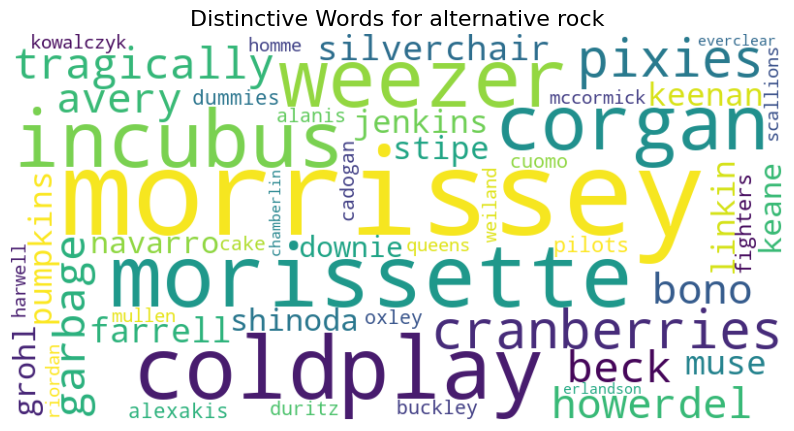

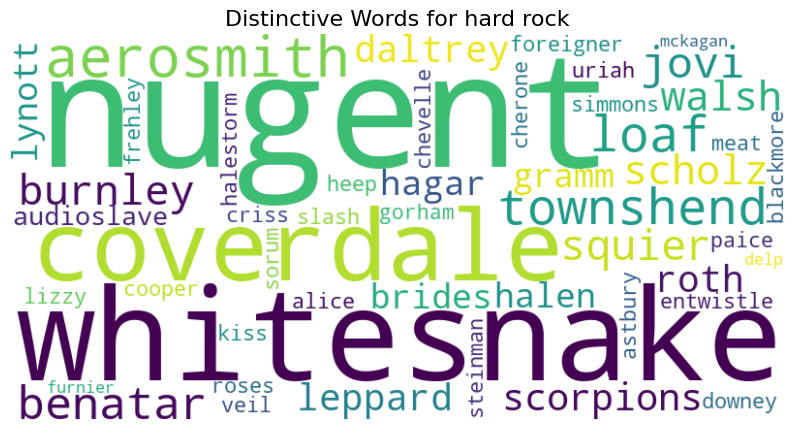

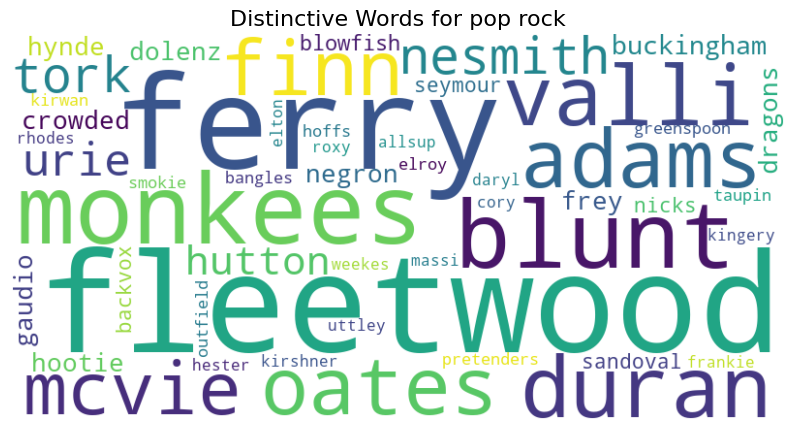

In [36]:
def create_genre_wordcloud(genre_name, genre_tfidf, figsize=(10, 6)):
    if genre_name not in genre_tfidf:
        print(f"Genre '{genre_name}' not found")
        return
    
    # Scale up the scores for visibility
    scores = genre_tfidf[genre_name]
    scaled_scores = {word: score * 100000 for word, score in scores.items()}
    
    wordcloud = WordCloud(width=800,
                          height=400,
                          background_color='white',
                          colormap='viridis',
                          max_words=50).generate_from_frequencies(scaled_scores)
    
    plt.figure(figsize=figsize)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Distinctive Words for {genre_name}', fontsize=16)
    plt.show()

for genre_name in top_communities[:3]:
    create_genre_wordcloud(genre_name, genre_tfidf)

The above seen wordclouds are calculated from the TF-IDF scores based on words in the communities - meaning each distinct word has been tallied up over all text in the community. The size of the words in the wordcloud denotes how distinct this word is for the community.

And as one might expect, band names or names of prolific characters within the genre is very distinct to that given genre.

## Part 4:


### Sentiment analysis

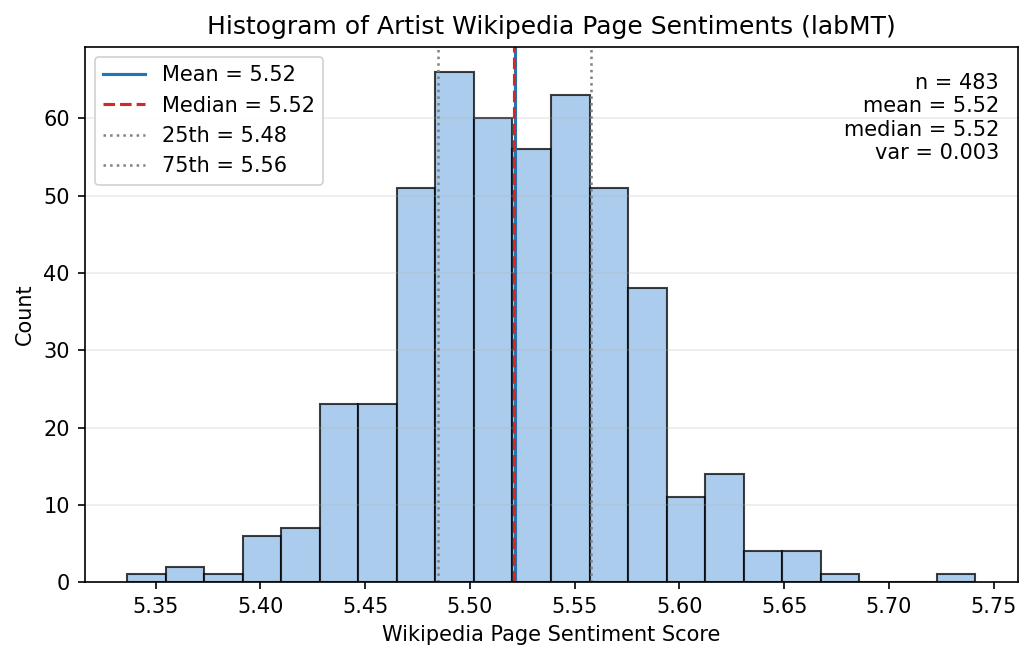

In [123]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1) Collect values (change the attribute name if you used a different key) ---
sent_attr = "happiness_average"   # e.g., "happiness_avg" or "happiness_avg_stoplist"
vals = [d.get(sent_attr) for _, d in G_rock.nodes(data=True)]
vals = np.array([v for v in vals if v is not None], dtype=float)
if vals.size == 0:
    raise ValueError("No sentiment values found on nodes.")

# --- 2) Summary stats ---
mean_h   = float(np.mean(vals))
median_h = float(np.median(vals))
p25      = float(np.percentile(vals, 25))
p75      = float(np.percentile(vals, 75))
var_h    = float(np.var(vals))
n        = int(vals.size)

# --- 3) Nice binning (Freedman–Diaconis, fallback to sqrt) ---
try:
    bin_edges = np.histogram_bin_edges(vals, bins="fd")
    if len(bin_edges) < 5:
        raise RuntimeError
except Exception:
    bin_edges = np.histogram_bin_edges(vals, bins="sqrt")

# --- 4) Plot ---
fig, ax = plt.subplots(figsize=(7, 4.5), dpi=150)

# Histogram: counts (Week 2 often used counts); set density=True if you prefer PDFs
ax.hist(vals, bins=bin_edges, color="#8fbce6", edgecolor="black", alpha=0.75)

# Reference lines
ax.axvline(mean_h,   color="#1f77b4", linestyle="-",  linewidth=1.5, label=f"Mean = {mean_h:.2f}")
ax.axvline(median_h, color="#d62728", linestyle="--", linewidth=1.5, label=f"Median = {median_h:.2f}")
ax.axvline(p25,      color="gray",    linestyle=":",  linewidth=1.2, label=f"25th = {p25:.2f}")
ax.axvline(p75,      color="gray",    linestyle=":",  linewidth=1.2, label=f"75th = {p75:.2f}")

# Labels / title
ax.set_title("Histogram of Artist Wikipedia Page Sentiments (labMT)")
ax.set_xlabel("Wikipedia Page Sentiment Score")
ax.set_ylabel("Count")

# Grid, legend, and a compact stat box
ax.grid(True, axis="y", alpha=0.25)
leg = ax.legend(frameon=True, framealpha=0.9)
leg.get_frame().set_linewidth(0.8)

text = f"n = {n}\nmean = {mean_h:.2f}\nmedian = {median_h:.2f}\nvar = {var_h:.3f}"
ax.text(0.98, 0.95, text, transform=ax.transAxes, ha="right", va="top")

plt.tight_layout()
plt.show()

The sentiment score is stored per node, as an avg. over all words on the artist's wikipedia page that are found in the labMT lexicon. According to scientific paper, "Temporal Patterns of Happiness and Information in a Global Social Network: Hedonometrics and Twitter", which was the study basis for the labMT lexicon, it is denoted that a score of 5 is neutral while scores above 5 are 'happy' and below 5 are 'sad.

The histogram shows the distribution of sentiment scores across all artist wikipedia pages in the network. The mean sentiment score over all artists is 5.52, meaning the overall sentiment is slightly happy. The median score is 5.52, which is very close to the mean, indicating a fairly symmetric distribution of sentiment scores.

It can be derived from the 25th and 75th percentiles that most artist pages use almost identical and neutral language. Thus is further supported by a very low variance of 0.003, indicating that the sentiment scores are closely clustered around the mean.

This result is expected, as wikipedia articles are meant to be neutral and factual in tone, avoiding overly positive or negative language.



### Sentiment analysis over communities

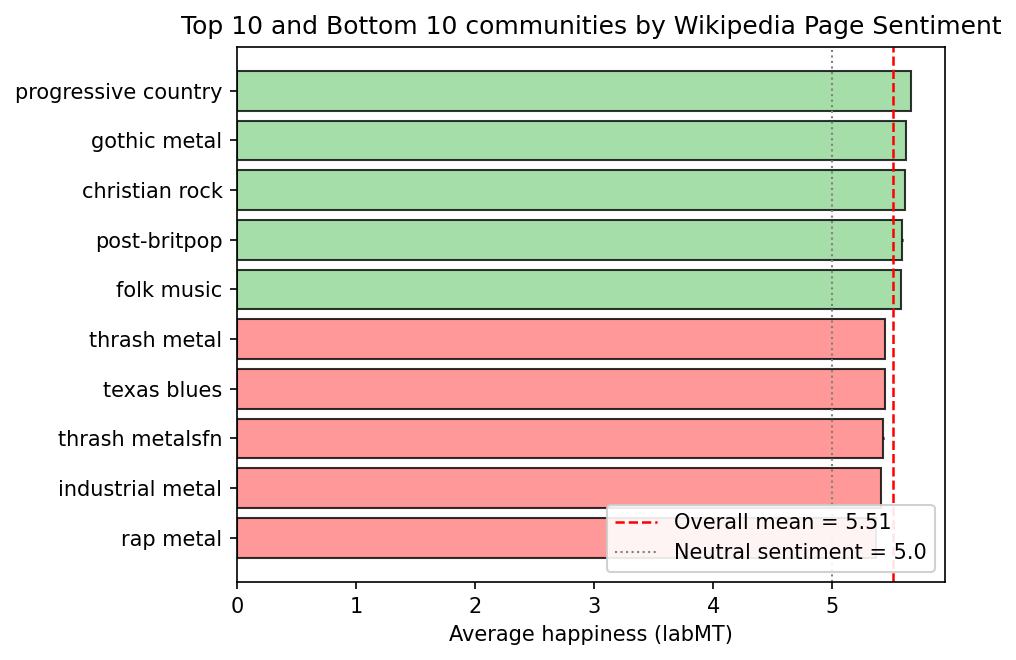

In [124]:
genre_sentiment = []
for genre, nodes in genre_to_nodes.items():
    sentiment = 0
    for node in nodes:
        node_sentiment = G_rock.nodes[node].get("happiness_average", None)
        if node_sentiment is not None:
            sentiment += node_sentiment
    genre_sentiment.append((genre, sentiment / len([n for n in nodes if G_rock.nodes[n].get("happiness_average", None) is not None]) if nodes else 0))

genre_sentiment.sort(key=lambda x: x[1], reverse=True)


# genre_sentiment is assumed to be a sorted list of (genre, avg_sentiment)
# If not sorted ascending, sort it first
genre_sentiment.sort(key=lambda x: x[1])

#Variance
sentiments = [s for _, s in genre_sentiment if s > 0]
variance = np.var(sentiments)

# Extract the 10 lowest and 10 highest
lowest_10 = genre_sentiment[:5]
highest_10 = genre_sentiment[-5:]

# Combine for plotting (lowest first, then highest)
combined = lowest_10 + highest_10
genres, means = zip(*combined)

# Compute overall mean (excluding zero/None)
overall_mean = np.mean([m for _, m in genre_sentiment if m > 0])

# Create color map: one color for low, another for high
colors = ["#ff7f7f"] * 5 + ["#8fd694"] * 5  # red-ish for low, green-ish for high

# Plot
fig, ax = plt.subplots(figsize=(6.5, 4.5), dpi=150)
y_positions = np.arange(len(genres))

ax.barh(y_positions, means, xerr=variance, color=colors, edgecolor="black", alpha=0.8)
ax.axvline(overall_mean, color="red", linestyle="--", linewidth=1.2, label=f"Overall mean = {overall_mean:.2f}")
ax.axvline(5.0, color="gray", linestyle=":", linewidth=1.0, label="Neutral sentiment = 5.0")

# Labels and title
ax.set_yticks(y_positions)
ax.set_yticklabels(genres)
ax.set_xlabel("Average happiness (labMT)")
ax.set_title("Top 10 and Bottom 10 communities by Wikipedia Page Sentiment")
ax.legend(loc="lower right", frameon=True, framealpha=0.9)

# Clean up layout
plt.tight_layout()
plt.show()

When looking at the sentiment over the different communities, we find a overall mean of 5.51, which is very close to the overall mean of all artist pages - the slightly lower mean is likely due to the exclusion of some pages, where sub-genres could not be found.

All communities have a mean over the neutral score of 5 indicating that most communities still use slightly positive language on their respective artists wiki pages. The variance over the communities is 0.0022 meaning that there is a low spread in sentiment between the different communities.

## Work distribution

Both group members read through the report and contributed. Lucas had the main responsibility for part 1 and 4. Søren had main responsibility for part 2 and 3.